<a href="https://colab.research.google.com/github/prathamchintamani/neuralnets/blob/main/tiny_vgg_architecture_MNISTmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
train_data = datasets.MNIST(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor(),
    target_transform = None
)

test_data = datasets.MNIST(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 17674463.52it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 478999.79it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4342088.21it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4133332.34it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
image, label = train_data[0]

Text(0.5, 1.0, '5')

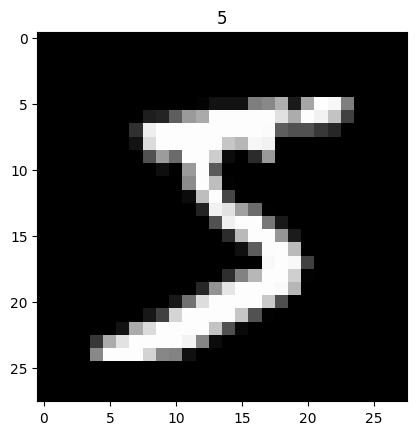

In [5]:
plt.imshow(image.squeeze(), cmap = 'gray')
plt.title(label)

In [6]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_dataloader = DataLoader(
    test_data,
    batch_size = BATCH_SIZE,
    shuffle = False
)

In [7]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))

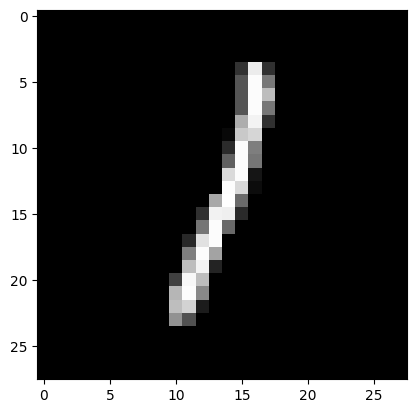

In [8]:
plt.imshow(train_features_batch[0].squeeze(), cmap = 'gray')

In [9]:
flatten_model = nn.Flatten()

In [10]:
# Create a convolutional neural network
class MNISTModel(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x


In [11]:
model0 = MNISTModel(input_shape=1,
    hidden_units=10,
    output_shape=10).to(device)
model0

MNISTModel(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [12]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [14]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [15]:
from tqdm.auto import tqdm

In [16]:
epochs = 20
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model0,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model0,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.36215 | Train accuracy: 87.58%
Test loss: 0.07299 | Test accuracy: 97.55%

Epoch: 1
---------
Train loss: 0.08034 | Train accuracy: 97.54%
Test loss: 0.08167 | Test accuracy: 97.31%

Epoch: 2
---------
Train loss: 0.06215 | Train accuracy: 98.06%
Test loss: 0.04689 | Test accuracy: 98.43%

Epoch: 3
---------
Train loss: 0.05153 | Train accuracy: 98.43%
Test loss: 0.05076 | Test accuracy: 98.34%

Epoch: 4
---------
Train loss: 0.04601 | Train accuracy: 98.55%
Test loss: 0.03522 | Test accuracy: 98.76%

Epoch: 5
---------
Train loss: 0.04033 | Train accuracy: 98.75%
Test loss: 0.03546 | Test accuracy: 98.80%

Epoch: 6
---------
Train loss: 0.03757 | Train accuracy: 98.80%
Test loss: 0.03532 | Test accuracy: 98.87%

Epoch: 7
---------
Train loss: 0.03538 | Train accuracy: 98.86%
Test loss: 0.03949 | Test accuracy: 98.78%

Epoch: 8
---------
Train loss: 0.03293 | Train accuracy: 98.95%
Test loss: 0.04065 | Test accuracy: 98.55%

Epoch: 9
---------
Train los